<a href="https://colab.research.google.com/github/Condemor-bit/SEFAC_IA/blob/main/RAG_simple_diciembre_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# instalamos librerias que vamos a utilizar.
!pip install -U bitsandbytes
!pip install -U transformers accelerate
!pip install pymupdf
!pip install llama-index llama-index-llms-huggingface llama-index-embeddings-huggingface

In [ ]:
#llamamos a las librerias necesarias que vamos a utilizar
import os
import fitz
from typing import List, Optional
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings
import torch


In [ ]:
# Crea el directorio "data" que leeremos el contenido
!mkdir -p data

#descarga guia spfa
!wget "https://www.farmaceuticos.com/wp-content/uploads/2024/02/GUIA_SPFA_FORO_2024_V15_AC-digital.pdf"

pdf_filename = "GUIA_SPFA_FORO_2024_V15_AC-digital.pdf" #guardamos el nombre del archivo en la variable pdf_filename


#Debido a que algunos archivos PDF son difíciles de leer, en la siguiente parte los convertiremos a texto plano en formato Markdown, el cual los modelos de lenguaje pueden procesar con mayor facilidad.

#Leer PDF con PyMuPDF
doc = fitz.open(pdf_filename)
markdown_text = ""


for page_num, page in enumerate(doc, start=1):
    text = page.get_text()
    markdown_text += f"### Página {page_num}\n\n{text}\n\n"


# Guardamos en formato Markdown en carpeta /data (Texto plano)
md_filename = pdf_filename.replace(".pdf", ".md")
md_path = os.path.join("data", md_filename)

with open(md_path, "w", encoding="utf-8") as f:
    f.write(markdown_text)


Language Technologies Laboratory @ Barcelona Supercomputing Center
https://huggingface.co/BSC-LT

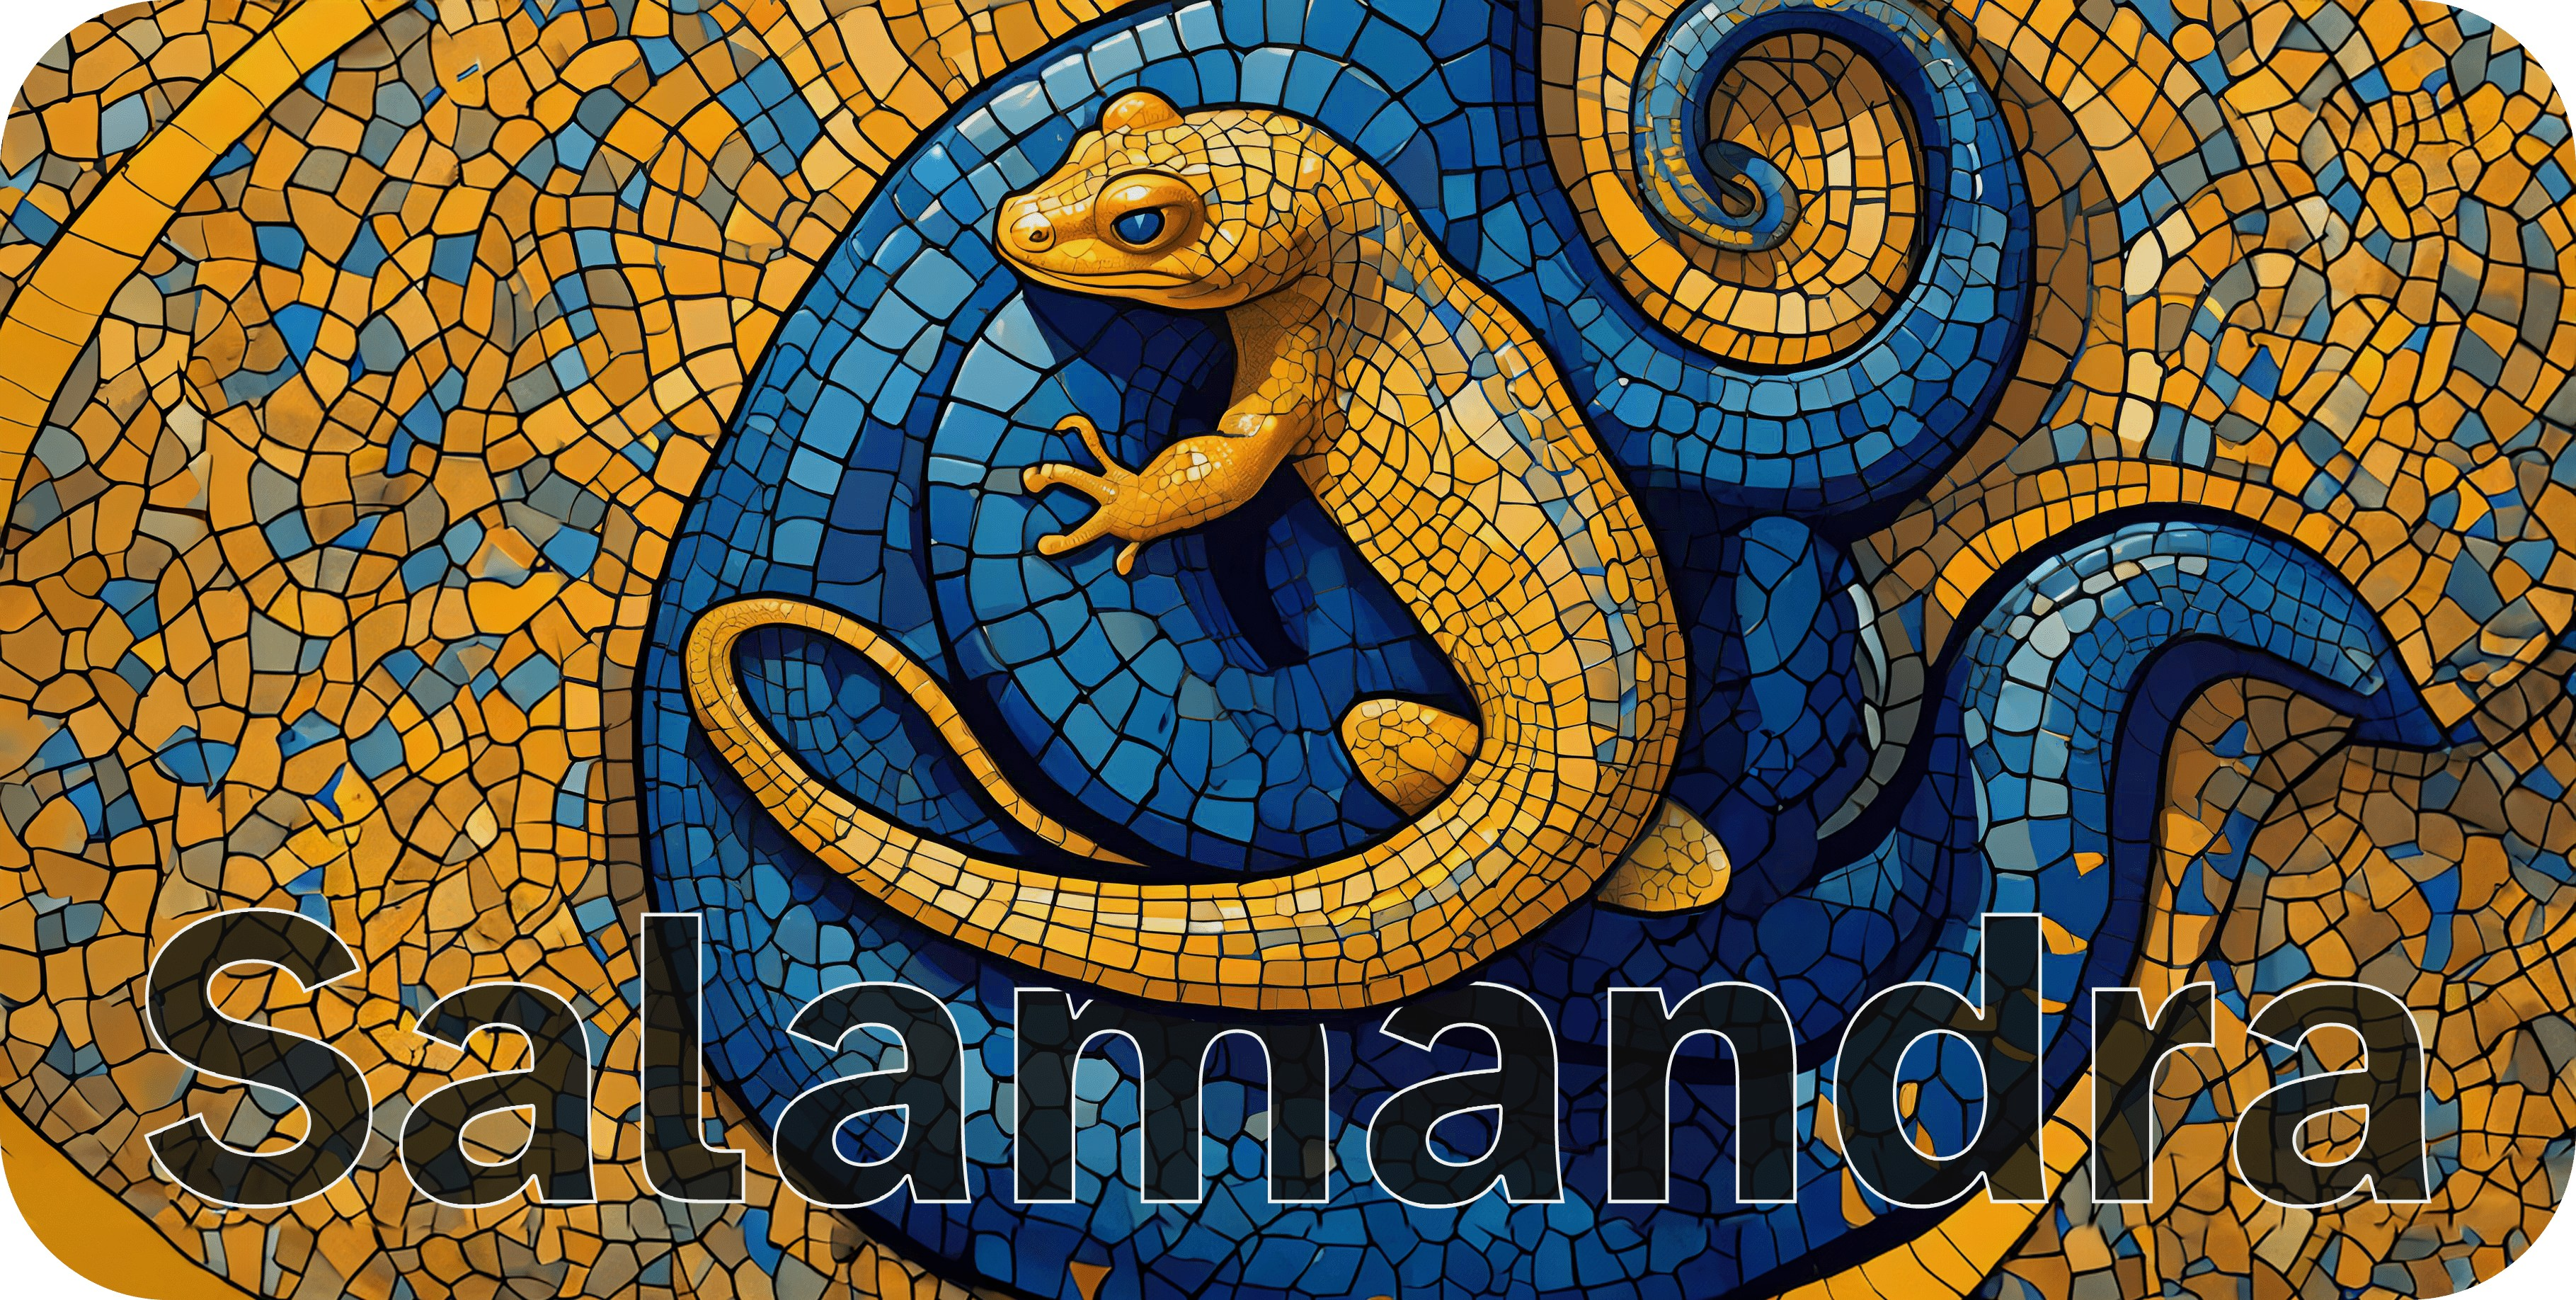


In [ ]:
### setting llamaindex
### ajustamos modelo de embedding local multilingüe --> búsqueda semántica
Settings.embed_model = HuggingFaceEmbedding(model_name="intfloat/multilingual-e5-base")

### ajustamos modelo local que genera la respuesta
Settings.llm = HuggingFaceLLM(
    model_name= "BSC-LT/salamandra-2b-instruct",  # Modelo LLM
    tokenizer_name="BSC-LT/salamandra-2b-instruct",  # Usa el mismo tokenizer
    context_window=2048,
    max_new_tokens=128,
    generate_kwargs={"temperature": 0.0, "do_sample": False}, ## determinista
)



#documentación https://developers.llamaindex.ai/python/examples/

## usar modelo openai
#from llama_index.llms.openai import OpenAI
#export OPENAI_API_KEY="tu_clave_aqui"
#Settings.llm = OpenAI(
#    model="gpt-4o-mini",       # gpt-4-turbo, gpt-3.5-turbo, etc.
#    temperature=0.0,           # determinista
#)

#usar embedding openai
#from llama_index.embeddings.openai import OpenAIEmbedding
#Settings.embed_model = OpenAIEmbedding(
#    model="text-embedding-3-small", embed_batch_size=100)

In [ ]:
#### Generar un RAG simple con llamaindex

#leemos el directorio data
documents = SimpleDirectoryReader("data").load_data()
#genera base de datos de vectores con el modelo de embedding
index = VectorStoreIndex.from_documents(documents) # Se puede guardar en un archivo y cargarlo si tenemos muchos archivos y los utilizamos muchas veces.
# Crear motor de consulta
query_engine = index.as_query_engine()

In [ ]:
#genera la respuesta a la pregunta.
response = query_engine.query("Lista los miembros que conforman el panel de expertos. en el siguiente formato -nombre apellidos")
print(response.response)

In [ ]:
#genera la respuesta a la pregunta.
response = query_engine.query("Según el contexto, ¿Quién es Vicente J. Baixauli Fernández?")
print(response.response)


# PROBAMOS EL MODELO DE 7B EN 4-BITS DE PRECISIÓN

Es necesario reiniciar la sesión y volver a cargar las librerías para eliminar el modelo anterior y evitar errores de memoria.

#### ¿Qué es la cuantización?

La cuantización es una técnica que se usa para hacer que los modelos de inteligencia artificial ocupen menos espacio y funcionen más rápido.
Consiste en reducir la precisión de los números que usa el modelo (por ejemplo, pasar de usar 32 bits a 4 bits).
Aunque el modelo se vuelve un poco menos preciso, consume menos memoria y puede ejecutarse más fácilmente en computadoras o dispositivos con pocos recursos.

In [ ]:
#cargamos el modelo con la libreria transformers de huggingface

model_name="BSC-LT/salamandra-7b-instruct"

###############
##si quieres usar moodelos de google y otros que necesitan permiso de uso usar esta parte.
#from huggingface_hub import login
#login(token="hf_XXXXXX")### aquí se pondría el token
#model_name="google/gemma-2-9b-it"
############


# Configuración quantization 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype= torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, ## aquí le decimos que lo cargue con la cuantización
    device_map="auto",
)

In [ ]:
### ajustamos modelo de embedding local multilingüe --> búsqueda semántica
Settings.embed_model = HuggingFaceEmbedding(model_name="intfloat/multilingual-e5-base")

### ajustamos modelo local que genera la respuesta

Settings.llm = HuggingFaceLLM(
    model= model,
    tokenizer = tokenizer,
    context_window=2048,
    max_new_tokens=128,
    generate_kwargs={"temperature": 0.0, "do_sample": False}, ## determinista
)

In [ ]:
#leemos el directorio data
documents = SimpleDirectoryReader("data").load_data()
#genera base de datos de vectores con el modelo de embedding
index = VectorStoreIndex.from_documents(documents)
# Crear motor de consulta
query_engine = index.as_query_engine()

In [ ]:
#genera la respuesta a la pregunta.
response = query_engine.query("Lista los miembros que conforman el panel de expertos. en el siguiente formato -nombre apellidos")
print(response.response)

In [ ]:
#genera la respuesta a la pregunta.
response = query_engine.query("Según el contexto, ¿Quién es Vicente J. Baixauli Fernández?")
print(response.response)


# TOKEN DE HUGGING FACE


In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/uBSbgQ1qPHI?si=GJR7sLc9oMcHQ83Q" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

Ir al modelo cuyo uso necesitemos aceptar para aprobar su política de uso.
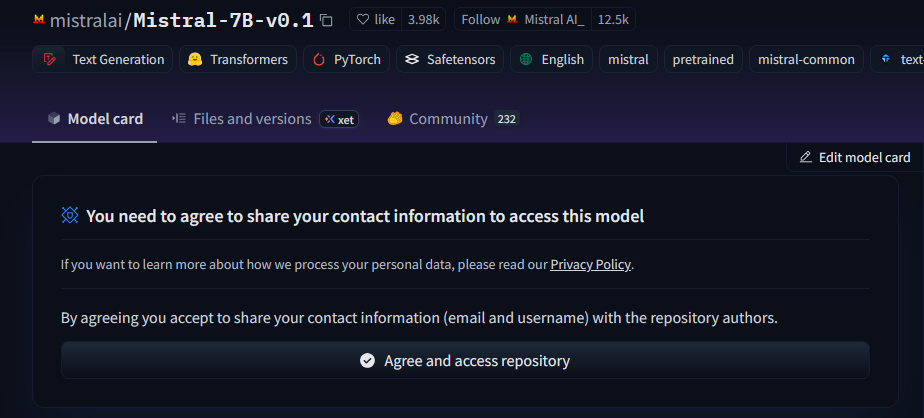